### Structure and Train models for final product



In [641]:
import os
import numpy as np
import pandas as pd
import tifffile as tif
import random
import scipy as sci

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import pickle

import sklearn

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [642]:
EPOCHS = 3


img_size = [64, 64, 1]
label_encoding = {
    # CdTe
    'Bulk': [1,0,0,0,0,0,0,0],
    'LC': [0,1,0,0,0,0,0,0],
    'SF1': [0,0,1,0,0,0,0,0],
    'Vacancy': [0,0,0,1,0,0,0,0],
    'interstitial': [0,0,0,0,1,0,0,0],
    'SF2': [0,0,0,0,0,1,0,0],
    'Twin': [0,0,0,0,0,0,1,0],  
    # STO features
    'Extra': [0,0,0,0,1,0,0,0], # same as interstitial
    'IExtra': [0,0,0,0,0,0,0,1],  # new
    'Mis': [0,0,0,1,0,0,0,0],  # same as vacancy
}
label_count = 1#len(label_encoding.keys()) - 2
current_target = 4 # of matrix from above dict to train for 
fileName = 'CdTe_Int_s.bin'
sto_model = False

In [643]:
def load_dataset():
    labels = os.listdir('DataSet_CdTe/')
    dataset = []
    for image in labels:
        import_img = tif.imread('DataSet_CdTe/' + image)
        if import_img.shape != (64, 64):
            import_img = import_img[:,:,0]
        import_img = import_img / np.max(import_img)
        import_img =  sci.ndimage.gaussian_filter(import_img, 1)
        import_img = np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(import_img))))
        import_img = (import_img > 1) * import_img
        dataset.append(import_img)
    return dataset, labels

def format_labels(ylabels):
    for entry in range(len(ylabels)):
        ylabels[entry] = ylabels[entry].split('_')[0]
        ylabels[entry] = label_encoding[ylabels[entry]]
    return ylabels

def format_dataset(xSet):
    for entry in range(np.shape(xSet)[0]):
        xSet[entry] = tf.convert_to_tensor(xSet[entry], dtype=tf.float32)
    return xSet

In [644]:
def load_aux_dataset():
    labels = os.listdir('DataSet_CdTe_Sam/')
    dataset = []
    for image in labels:
        import_img = tif.imread('DataSet_CdTe_Sam/' + image)
        if import_img.shape != (64, 64):
            import_img = import_img[:,:,0]
        import_img = import_img / np.max(import_img)
        import_img =  sci.ndimage.gaussian_filter(import_img, 1)
        import_img = np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(import_img))))
        import_img = (import_img > 1) * import_img
        dataset.append(import_img)
    return dataset, labels

In [645]:
def load_sto_data():
    labels = os.listdir('DataSet_STO/')
    dataset = []
    for image in labels:
        import_img = tif.imread('DataSet_STO/' + image) / 255
        if import_img.shape != (64, 64):
            import_img = import_img[:,:,0] 
        import_img = import_img / np.max(import_img)
        import_img =  sci.ndimage.gaussian_filter(import_img, 1)
        import_img = np.log(1 + np.abs(np.fft.fftshift(np.fft.fft2(import_img))))
        import_img = (import_img > 1) * import_img
        dataset.append(import_img)
    return dataset, labels

In [646]:
init = tf.keras.initializers.HeNormal()

cnn_model = keras.Sequential(name='ImageClassificationCNN')
cnn_model.add(keras.layers.Input(shape=img_size))

cnn_model.add(keras.layers.Conv2D(filters=64, kernel_size=(1, 1), activation=None, kernel_initializer=init, padding='valid'))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.Activation('selu'))

cnn_model.add(keras.layers.Conv2D(filters=64, kernel_size=(8, 8), activation=None, kernel_initializer=init, padding='valid'))
cnn_model.add(keras.layers.BatchNormalization())
cnn_model.add(keras.layers.Activation('selu'))

cnn_model.add(keras.layers.Conv2D(filters=64, kernel_size=(1, 1), activation=None, kernel_initializer=init, padding='valid'))
cnn_model.add(keras.layers.BatchNormalization(name='Norm_1'))
cnn_model.add(keras.layers.Activation('selu'))

cnn_model.add(keras.layers.MaxPooling2D(pool_size=2, name='Pooling_2'))
# line below is commented in s_ version, and many others... stable may have been corrupted/overwritten on accident
#cnn_model.add(keras.layers.Dense(128, activation='selu', name='Dense_1'))
cnn_model.add(keras.layers.Dense(32, activation='selu', name='Dense_2'))
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(label_count, activation='sigmoid', name='Output_Dense'))

cnn_model.compile(loss='BinaryCrossentropy',optimizer='Adam',metrics=['accuracy'])

cnn_model.summary()

Model: "ImageClassificationCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 64, 64, 64)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 57, 57, 64)     │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 57, 57, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ (None, 57, 57, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 57, 57, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Norm_1 (BatchNormalization)     │ (None, 57, 57, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 57, 57, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling_2 (MaxPooling2D)        │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 28, 28, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Dense (Dense)            │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 294,433 (1.12 MB)

 Trainable params: 294,049 (1.12 MB)

 Non-trainable params: 384 (1.50 KB)

In [647]:

img_ds, labels = load_dataset()
if not sto_model:
    img_ds1, labels1 = load_aux_dataset()
    img_ds = img_ds + img_ds1
    labels = labels + labels1
if sto_model:
    img_ds1, labels1 = load_sto_data()
    img_ds = img_ds1
    labels = labels1

In [648]:

img_ds = np.array(format_dataset(img_ds))
labels = np.array(format_labels(labels))


new_shape = list(np.shape(img_ds))
new_shape.append(1)
img_ds = tf.reshape(img_ds, new_shape)


In [649]:
img_90 = np.rot90(img_ds, axes=[1,2])
img_180 = np.rot90(img_90, axes=[1,2])
img_270 = np.rot90(img_180, axes=[1,2])
img_ds = np.concatenate([img_ds, img_90, img_180, img_270])
labels = np.concatenate([labels, labels, labels, labels])

labels = pd.DataFrame(labels)
labels = labels[current_target]
labels = np.array(labels)

In [650]:
train_mix = list(zip(img_ds, labels))
random.shuffle(train_mix)
mix_data, mix_labels = zip(*train_mix)

In [651]:
training_data_stack = np.array_split(mix_data, 5)
training_labels_stack = np.array_split(mix_labels, 5)

testing_data = training_data_stack[4]
testing_labels = training_labels_stack[4]


In [652]:

training_data = np.concatenate(training_data_stack[:4])
training_labels = np.concatenate(training_labels_stack[:4])

training_data = np.array(training_data)
training_labels = np.array(training_labels)

In [653]:
history = []

In [654]:
if os.path.isfile(fileName):
    with open(fileName, 'rb') as file:
        cnn_model = pickle.load(file)

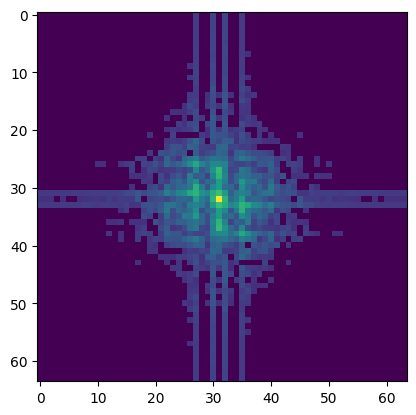

In [655]:
plt.imshow(training_data[0])

In [664]:
history.append(cnn_model.fit(training_data, training_labels, epochs=EPOCHS, batch_size=32))

Epoch 1/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 583ms/step - accuracy: 0.9636 - loss: 0.0992
Epoch 2/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 547ms/step - accuracy: 0.9800 - loss: 0.0619
Epoch 3/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 515ms/step - accuracy: 0.9904 - loss: 0.0361


In [665]:
with open(fileName, 'wb') as file:
    pickle.dump(cnn_model, file)

Text(0, 0.5, 'Loss')

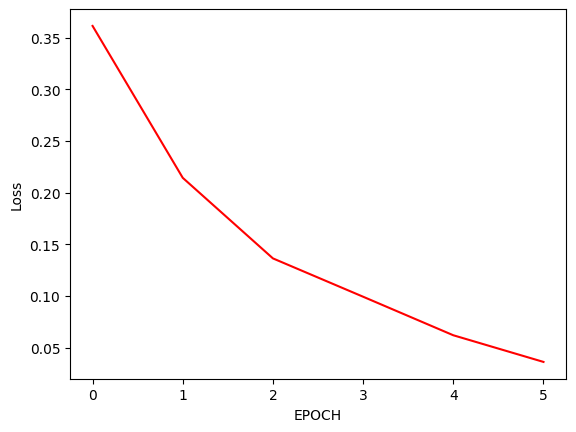

In [666]:
loss_history = []
for entry in history:
    loss_history = loss_history + entry.history['loss']

plt.figure()
plt.plot(loss_history, 'r-')
plt.xlabel('EPOCH')
plt.ylabel('Loss')

In [667]:
prediction = cnn_model.predict(testing_data)

36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step


In [668]:
pd.DataFrame(prediction).describe()

,0
count,1.140000e+03
mean,6.991491e-02
std,2.029140e-01
min,7.453953e-09
25%,8.522091e-05
50%,7.917083e-04
75%,1.059636e-02
max,9.996892e-01


In [669]:
prediction_indexes = []
label_indexes = []
for entry in prediction:
    prediction_indexes.append(entry > 0.5)
for entry in testing_labels:
    label_indexes.append(entry)


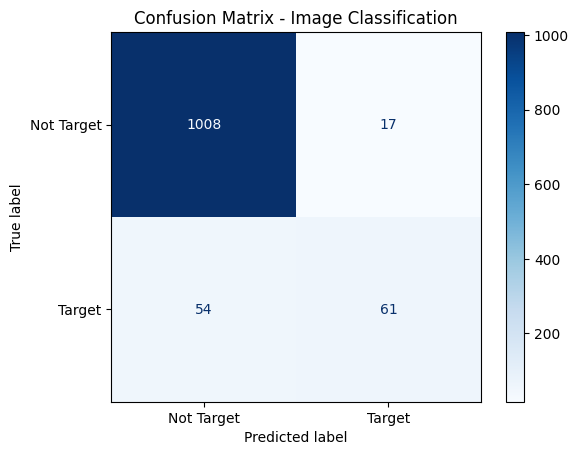

In [670]:
cm = confusion_matrix(label_indexes, prediction_indexes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Target', 'Target'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Image Classification')
plt.grid(False)
plt.show()

In [671]:
print(classification_report(label_indexes,prediction_indexes))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1025
           1       0.78      0.53      0.63       115

    accuracy                           0.94      1140
   macro avg       0.87      0.76      0.80      1140
weighted avg       0.93      0.94      0.93      1140

